# Parsing Clinical Trial Eligibility Criteria Using Transformers

In [1]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from shutil import copyfile
import csv

In [2]:
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

## Chia Preprocessing

In [3]:
inputpath = f"chia/chia_with_scope"
outputpath = f"chia/chia_bio"
trainpath = f"chia/trains"
testpath = f"chia/tests"

In [4]:
# Load input files names
inputfiles = set()
for f in os.listdir(inputpath):
    if f.endswith('.ann'):
        inputfiles.add(f.split('.')[0].split('_')[0])
len(inputfiles)

1000

In [5]:
# list of entity types to retain
select_types = ['Condition', 'Value', 'Drug', 'Procedure', 'Measurement', 'Temporal', \
    'Observation', 'Person', 'Mood', 'Device', 'Pregnancy_considerations']

In [6]:
# convert Brat format into BIO format
# function for getting entity annotations from the annotation file
def get_annotation_entities(ann_file, select_types=None):
    entities = []
    with open(ann_file, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith('T'):
                term = line.strip().split('\t')[1].split()
                if (select_types != None) and (term[0] not in select_types): continue
                if int(term[-1]) <= int(term[1]): continue
                entities.append((int(term[1]), int(term[-1]), term[0]))
    return sorted(entities, key=lambda x: (x[0], x[1]))

# function for handling overlap by keeping the entity with largest text span
def remove_overlap_entities(sorted_entities):
    keep_entities = []
    for idx, entity in enumerate(sorted_entities):
        if idx == 0:
            keep_entities.append(entity)
            last_keep = entity
            continue
        if entity[0] < last_keep[1]:
            if entity[1]-entity[0] > last_keep[1]-last_keep[0]:
                last_keep = entity
                keep_entities[-1] = last_keep
        elif entity[0] == last_keep[1]:
            last_keep = (last_keep[0], entity[1], last_keep[-1])
            keep_entities[-1] = last_keep
        else:
            last_keep = entity
            keep_entities.append(entity)
    return keep_entities

# inverse index of entity annotations
def entity_dictionary(keep_entities, txt_file):
    f_ann = {}
    with open(txt_file, "r", encoding="utf-8") as f:
        text = f.readlines()
        if file in ['NCT02348918_exc', 'NCT02348918_inc', 'NCT01735955_exc']:
            text = ' '.join([i.strip() for i in text])
        else:
            text = '  '.join([i.strip() for i in text])
    for entity in keep_entities:
        entity_text = text[entity[0]:entity[1]]
        doc = nlp(entity_text)
        token_starts = [(i, doc[i:].start_char) for i in range(len(doc))]
        term_type = entity[-1]
        term_offset = entity[0]
        for i, token in enumerate(doc):
            ann_offset = token_starts[i][1]+term_offset
            if ann_offset not in f_ann:
                f_ann[ann_offset] = [i, token.text, term_type]
    return f_ann

# Brat -> BIO format conversion
for infile in inputfiles:
    for t in ["exc", "inc"]:
        file = f"{infile}_{t}"
        ann_file = f"{inputpath}/{file}.ann"
        txt_file = f"{inputpath}/{file}.txt"
        out_file = f"{outputpath}/{file}.bio.txt"
        sorted_entities = get_annotation_entities(ann_file, select_types)
        keep_entities = remove_overlap_entities(sorted_entities)
        f_ann = entity_dictionary(keep_entities, txt_file)
        with open(out_file, "w", encoding="utf-8") as f_out:
            with open(txt_file, "r", encoding="utf-8") as f:
                sent_offset = 0
                for line in f:
                    # print(line.strip())
                    if '⁄' in line:
                        # print(txt_file)
                        line = line.replace('⁄', '/') # replace non unicode characters
                    doc = nlp(line.strip())
                    token_starts = [(i, doc[i:].start_char) for i in range(len(doc))]
                    for token in doc:
                        token_sent_offset = token_starts[token.i][1]
                        token_doc_offset = token_starts[token.i][1]+sent_offset
                        if token_doc_offset in f_ann:
                            if f_ann[token_doc_offset][0] == 0:
                                label = f"B-{f_ann[token_doc_offset][2]}"
                            else:
                                label = f"I-{f_ann[token_doc_offset][2]}"
                        else:
                            label = f"O"
                        # print(token.text, token_sent_offset, token_sent_offset+len(token.text), token_doc_offset, token_doc_offset+len(token.text), label)
                        f_out.write(f"{token.text} {token_sent_offset} {token_sent_offset+len(token.text)} {token_doc_offset} {token_doc_offset+len(token.text)} {label}\n")
                    # print('\n')
                    f_out.write('\n')
                    if file in ['NCT02348918_exc', 'NCT02348918_inc', 'NCT01735955_exc']: # 3 trials with inconsistent offsets
                        sent_offset += (len(line.strip())+1)
                    else:
                        sent_offset += (len(line.strip())+2)

In [7]:
# dataset separation: 800 trials (80%) for training, 100 trials (10%) for validation and 100 trials (10%) for testing
train_ids, dev_ids = train_test_split(list(inputfiles), train_size=0.8, random_state=13, shuffle=True)
dev_ids, test_ids = train_test_split(dev_ids, train_size=0.5, random_state=13, shuffle=True)
print(len(train_ids), len(dev_ids), len(test_ids))
chia_datasets = {"train":train_ids, "dev":dev_ids, "test":test_ids}
json.dump(chia_datasets, open("chia/chia_datasets.json", "w", encoding="utf-8"))

800 100 100


In [8]:
# Merge BIO format train, validation and test datasets
# chia_datasets = json.load(open("chia/chia_datasets.json", "r", encoding="utf-8"))
# merge the train dataset
with open("chia/train.txt", "w", encoding="utf-8") as f:
    for fid in chia_datasets["train"]:
        copyfile(f"{outputpath}/{fid}_exc.bio.txt", f"{trainpath}/{fid}_exc.bio.txt")
        copyfile(f"{outputpath}/{fid}_inc.bio.txt", f"{trainpath}/{fid}_inc.bio.txt")
        with open(f"{outputpath}/{fid}_exc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")
        with open(f"{outputpath}/{fid}_inc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

# merge the validation dataset
with open("chia/dev.txt", "w", encoding="utf-8") as f:
    for fid in chia_datasets["dev"]:
        copyfile(f"{outputpath}/{fid}_exc.bio.txt", f"{trainpath}/{fid}_exc.bio.txt")
        copyfile(f"{outputpath}/{fid}_inc.bio.txt", f"{trainpath}/{fid}_inc.bio.txt")
        with open(f"{outputpath}/{fid}_exc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")
        with open(f"{outputpath}/{fid}_inc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

# merge the test dataset
with open("chia/test.txt", "w", encoding="utf-8") as f:
    for fid in chia_datasets["test"]:
        copyfile(f"{outputpath}/{fid}_exc.bio.txt", f"{testpath}/{fid}_exc.bio.txt")
        copyfile(f"{outputpath}/{fid}_inc.bio.txt", f"{testpath}/{fid}_inc.bio.txt")
        with open(f"{outputpath}/{fid}_exc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")
        with open(f"{outputpath}/{fid}_inc.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

In [9]:
# convert Chia in Brat into format for Att-BiLSTM-CRF model
out_file = f"chia/chia_ner.tsv"
with open(out_file, "w", encoding="utf-8") as f_out:
    for infile in inputfiles:
        for t in ["exc", "inc"]:
            file = f"{infile}_{t}"
            ann_file = f"{inputpath}/{file}.ann"
            txt_file = f"{inputpath}/{file}.txt"
            sorted_entities = get_annotation_entities(ann_file, select_types)
            keep_entities = remove_overlap_entities(sorted_entities)
            with open(txt_file, "r", encoding="utf-8") as f:
                sent_offset = 0
                for line in f:
                    # print(line.strip())
                    if '⁄' in line: line = line.replace('⁄', '/')
                    sent_end = sent_offset + len(line)
                    sent_ents = []
                    for ent in keep_entities:
                        if ent[0] < sent_offset or ent[1] < sent_offset: continue
                        if ent[0] >= sent_end or ent[1] > sent_offset+len(line.strip()): break
                        ent_start = ent[0]-sent_offset+1
                        ent_end = ent[1]-sent_offset+1
                        sent_ents.append(f"{ent_start}:{ent_end}:{ent[2].lower()}")
                    if sent_ents == []:
                        if file in ['NCT02348918_exc', 'NCT02348918_inc', 'NCT01735955_exc']:
                            sent_offset += (len(line.strip())+1)
                        else:
                            sent_offset += (len(line.strip())+2)
                        continue
                    # print(f"{file}\t{','.join(sent_ents)}\t{line.strip()}")
                    f_out.write(f"{file}\t{','.join(sent_ents)}\t{line.strip()}")
                    # print('\n')
                    f_out.write('\n')
                    if file in ['NCT02348918_exc', 'NCT02348918_inc', 'NCT01735955_exc']:
                        sent_offset += (len(line.strip())+1)
                    else:
                        sent_offset += (len(line.strip())+2)

In [10]:
# split Chia in format for Att-BiLSTM-CRF model into train, validation and test datasets
# chia_datasets = json.load(open("chia/chia_datasets.json", "r", encoding="utf-8"))
with open("chia/chia_ner_train.tsv", "w", encoding="utf-8") as ftrain, open("chia/chia_ner_dev.tsv", "w", encoding="utf-8") as fdev, open("chia/chia_ner_test.tsv", "w", encoding="utf-8") as ftest:
    with open("chia/chia_ner.tsv", "r", encoding="utf-8") as fread:
        for line in fread:
            if line.split('\t', 1)[0].split("_")[0] in chia_datasets["train"]:
                ftrain.write(line)
            elif line.split('\t', 1)[0].split("_")[0] in chia_datasets["dev"]:
                fdev.write(line)
            else:
                ftest.write(line)

## Facebook Research Data (FRD) Preprocessing

In [11]:
fbnerfile = f"fbner/medical_ner.tsv"
outputpath = f"fbner/fb_bio"
trainpath = f"fbner/trains"
testpath = f"fbner/tests"

In [12]:
# loading FRD data
fbner = {}
with open(fbnerfile, "r", encoding='utf-8') as f:
    for line in f:
        line = line.strip().split('\t')
        ents = line[1].split(',')
        ents = [ent.split(':') for ent in ents]
        fbner[line[0]] = fbner.get(line[0], [])
        fbner[line[0]].append({'text':line[-1], 'entities':ents})
json.dump(fbner, open(f"./fbner/medical_ner.json", "w", encoding="utf-8"))
inputfiles = list(fbner.keys())

In [13]:
# convert FRD into BIO format
for k, v in fbner.items():
    out_file = f"{outputpath}/{k}.bio.txt"
    with open(out_file, "w", encoding="utf-8") as f_out:
        sent_offset = 0
        for sent in v:
            sent_text = sent['text']
            f_ann = {}
            # the entity location dictionary
            for ent in sent['entities']:
                entity_text = sent_text[int(ent[0])-1:int(ent[1])-1]
                doc = nlp(entity_text)
                token_starts = [(i, doc[i:].start_char) for i in range(len(doc))]
                term_type = ent[-1]
                term_offset = int(ent[0])-1+sent_offset
                for i, token in enumerate(doc):
                    ann_offset = token_starts[i][1]+term_offset
                    if ann_offset not in f_ann:
                        f_ann[ann_offset] = [i, token.text, term_type]
            # convert to bio format
            doc = nlp(sent_text)
            token_starts = [(i, doc[i:].start_char) for i in range(len(doc))]
            for token in doc:
                token_sent_offset = token_starts[token.i][1]
                token_doc_offset = token_starts[token.i][1]+sent_offset
                if token_doc_offset in f_ann:
                    if f_ann[token_doc_offset][0] == 0:
                        label = f"B-{f_ann[token_doc_offset][2]}"
                    else:
                        label = f"I-{f_ann[token_doc_offset][2]}"
                else:
                    label = f"O"
                # print(token.text, token_sent_offset, token_sent_offset+len(token.text), token_doc_offset, token_doc_offset+len(token.text), label)
                f_out.write(f"{token.text} {token_sent_offset} {token_sent_offset+len(token.text)} {token_doc_offset} {token_doc_offset+len(token.text)} {label}\n")
            # print('\n')
            f_out.write('\n')
            sent_offset += (len(sent_text)+1)

In [14]:
# split FRD into train, validation and test datasets
train_ids, dev_ids = train_test_split(inputfiles, train_size=0.8, random_state=13, shuffle=True)
dev_ids, test_ids = train_test_split(dev_ids, train_size=0.5, random_state=13, shuffle=True)
print(len(train_ids), len(dev_ids), len(test_ids))
fbner_datasets = {"train":train_ids, "dev":dev_ids, "test":test_ids}
json.dump(fbner_datasets, open("fbner/fbner_datasets.json", "w", encoding="utf-8"))

2651 331 332


In [15]:
# Merge BIO format train, validation and test datasets
# fbner_datasets = json.dump(open("fbner/fbner_datasets.json", "r", encoding="utf-8"))
# merge the train dataset
with open("fbner/train.txt", "w", encoding="utf-8") as f:
    for fid in fbner_datasets["train"]:
        copyfile(f"{outputpath}/{fid}.bio.txt", f"{trainpath}/{fid}.bio.txt")
        with open(f"{outputpath}/{fid}.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

# merge the validation dataset
with open("fbner/dev.txt", "w", encoding="utf-8") as f:
    for fid in fbner_datasets["dev"]:
        copyfile(f"{outputpath}/{fid}.bio.txt", f"{trainpath}/{fid}.bio.txt")
        with open(f"{outputpath}/{fid}.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

# merge the test dataset
with open("fbner/test.txt", "w", encoding="utf-8") as f:
    for fid in fbner_datasets["test"]:
        copyfile(f"{outputpath}/{fid}.bio.txt", f"{testpath}/{fid}.bio.txt")
        with open(f"{outputpath}/{fid}.bio.txt", "r", encoding="utf-8") as fr:
            txt = fr.read().strip()
            if txt != '':
                f.write(txt)
                f.write("\n\n")

In [16]:
# resplit the processed data
# fbner_datasets = json.load(open("fbner/fbner_datasets.json", "r", encoding="utf-8"))

with open("fbner/fbner_ner_train.tsv", "w", encoding="utf-8") as ftrain, open("fbner/fbner_ner_dev.tsv", "w", encoding="utf-8") as fdev, open("fbner/fbner_ner_test.tsv", "w", encoding="utf-8") as ftest:
    with open("fbner/medical_ner.tsv", "r", encoding="utf-8") as fread:
        for line in fread:
            if line.split('\t', 1)[0] in fbner_datasets["train"]:
                ftrain.write(line)
            elif line.split('\t', 1)[0] in fbner_datasets["dev"]:
                fdev.write(line)
            else:
                ftest.write(line)

## Att-BiLSTM-CRF Model Performance Anlysis

In [17]:
def abc_strict_match(gs, pred, s_idx, e_idx, ent_type):
    if s_idx == 0:
        for idx in range(s_idx, e_idx):
            if gs[idx] != pred[idx]:
                return False
        if e_idx < len(gs):
            if gs[e_idx] == ent_type or pred[e_idx] == ent_type:
                return False
    else:
        if gs[s_idx-1] == ent_type or pred[s_idx-1] == ent_type:
            return False
        for idx in range(s_idx, e_idx):
            if gs[idx] != pred[idx]:
                return False
        if e_idx < len(gs):
            if gs[e_idx] == ent_type or pred[e_idx] == ent_type:
                return False
    return True

def abc_relax_match(gs, pred, s_idx, e_idx, ent_type):
    for idx in range(s_idx, e_idx):
        if gs[idx] == pred[idx] == ent_type:
            return True
    return False

In [20]:
dataset = 'chia' # or 'frd', 'chia'
outfolder = f"attbilstmcrf"
outfile = f"{dataset}_attbilstmcrf_results.txt"
labels_dict = {'chia':['Mood', 'Condition', 'Procedure', 'Measurement', 'Value', 'Drug', 'Temporal', 'Observation', 'Pregnancy', 'Person', 'Device'], 'frd':['chronic_disease', 'treatment', 'upper_bound', 'pregnancy', 'clinical_variable', 'lower_bound', 'cancer', 'age', 'language_fluency', 'gender', 'contraception_consent', 'technology_access', 'allergy_name', 'bmi', 'ethnicity']}
labels = labels_dict[dataset]

In [21]:
eval_metrics = {"category":{},"overall":{}, "prediction":{}}
with open(f"{outfolder}/{outfile}", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        gs = eval(line.split('\t')[1])
        pred = eval(line.split('\t')[0])
        for i in zip(gs, pred):
            if i[0] == i[1]: eval_metrics["overall"]["acc_true"] = eval_metrics["overall"].get("acc_true", 0) + 1
            else: eval_metrics["overall"]["acc_false"] = eval_metrics["overall"].get("acc_false", 0) + 1
        llen = len(gs)
        cur_idx = 0
        while cur_idx < llen:
            if gs[cur_idx] == 0:
                cur_idx += 1
            else:
                start_idx = cur_idx
                end_idx = start_idx + 1
                cate = gs[start_idx]
                while end_idx < llen and gs[end_idx] == cate:
                    end_idx += 1
                eval_metrics["overall"]['gs'] = eval_metrics["overall"].get('gs', {})
                eval_metrics["overall"]['gs']['count'] = eval_metrics["overall"]['gs'].get('count', 0) + 1
                eval_metrics["overall"]['gs'][labels[cate-1]] = eval_metrics["overall"]['gs'].get(labels[cate-1], 0) + 1
                if abc_strict_match(gs, pred, start_idx, end_idx, cate):
                    eval_metrics["overall"]["strict_predicted"] = eval_metrics["overall"].get("strict_predicted", 0) + 1
                    eval_metrics["category"][labels[cate-1]] = eval_metrics["category"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][labels[cate-1]]["strict"] += 1
                elif abc_relax_match(gs, pred, start_idx, end_idx, cate):
                    eval_metrics["overall"]["relax_predicted"] = eval_metrics["overall"].get("relax_predicted", 0) + 1
                    eval_metrics["category"][labels[cate-1]] = eval_metrics["category"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][labels[cate-1]]["relax"] += 1
                else:
                    eval_metrics["overall"]["miss_predicted"] = eval_metrics["overall"].get("miss_predicted", 0) + 1
                    eval_metrics["category"][labels[cate-1]] = eval_metrics["category"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][labels[cate-1]]["miss"] += 1
                cur_idx = end_idx
        cur_idx = 0
        while cur_idx < llen:
            if pred[cur_idx] == 0:
                cur_idx += 1
            else:
                start_idx = cur_idx
                end_idx = start_idx + 1
                cate = pred[start_idx]
                while end_idx < llen and pred[end_idx] == cate:
                    end_idx += 1
                if abc_strict_match(gs, pred, start_idx, end_idx, cate):
                    eval_metrics["overall"]["strict_predict"] = eval_metrics["overall"].get("strict_predict", 0) + 1
                    eval_metrics["prediction"][labels[cate-1]] = eval_metrics["prediction"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][labels[cate-1]]["strict"] += 1
                elif abc_relax_match(gs, pred, start_idx, end_idx, cate):
                    eval_metrics["overall"]["relax_predict"] = eval_metrics["overall"].get("relax_predict", 0) + 1
                    eval_metrics["prediction"][labels[cate-1]] = eval_metrics["prediction"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][labels[cate-1]]["relax"] += 1
                else:
                    eval_metrics["overall"]["miss_predict"] = eval_metrics["overall"].get("miss_predict", 0) + 1
                    eval_metrics["prediction"][labels[cate-1]] = eval_metrics["prediction"].get(labels[cate-1], {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][labels[cate-1]]["miss"] += 1
                cur_idx = end_idx

In [22]:
attbc_metrics = {"category":{},"overall":{}}
attbc_metrics["overall"]["acc"] = eval_metrics["overall"]["acc_true"]/(eval_metrics["overall"]["acc_true"]+eval_metrics["overall"]["acc_false"])
pred_all = eval_metrics["overall"]['strict_predict'] + eval_metrics["overall"]['relax_predict'] + eval_metrics["overall"]['miss_predict']
pre_relax_all = (eval_metrics["overall"]['strict_predict'] + eval_metrics["overall"]['relax_predict'])/ pred_all
rec_relax_all = (eval_metrics["overall"]['strict_predicted'] + eval_metrics["overall"]['relax_predicted'])/ eval_metrics["overall"]['gs']['count']
f1_relax_all = (2*pre_relax_all*rec_relax_all)/(pre_relax_all+rec_relax_all)
print(f"Overall Relax Level: Precision: {pre_relax_all}, Recall: {rec_relax_all}, F1: {f1_relax_all}")
attbc_metrics["overall"]["relax"] = {"f_score": f1_relax_all, "precision":pre_relax_all, "recall":rec_relax_all}

pre_strict_all = eval_metrics["overall"]['strict_predict'] / pred_all
rec_strict_all = eval_metrics["overall"]['strict_predicted'] / eval_metrics["overall"]['gs']['count']
f1_strict_all = (2*pre_strict_all*rec_strict_all)/(pre_strict_all+rec_strict_all)
print(f"Overall Strict Level: Precision: {pre_strict_all}, Recall: {rec_strict_all}, F1: {f1_strict_all}")
print('\n')
attbc_metrics["overall"]["strict"] = {"f_score": f1_strict_all, "precision":pre_strict_all, "recall":rec_strict_all}

for i in eval_metrics["category"].keys():
    tt = eval_metrics["overall"]['gs'][i]
    tp = eval_metrics["prediction"][i]['strict'] + eval_metrics["prediction"][i]['relax'] + eval_metrics["prediction"][i]['miss']
    
    pre_relax = (eval_metrics["prediction"][i]['strict']+eval_metrics["prediction"][i]['relax'])/tp
    rec_relax = (eval_metrics["category"][i]['strict']+eval_metrics["category"][i]['relax'])/tt
    f1_relax = (2*pre_relax*rec_relax)/(pre_relax+rec_relax)
    print(f"Relax Level for {i}: Precision: {pre_relax}, Recall: {rec_relax}, F1: {f1_relax}")
    attbc_metrics["category"]["relax"] = attbc_metrics["category"].get("relax", {})
    attbc_metrics["category"]["relax"][i] = {"f_score": f1_relax, "precision":pre_relax, "recall":rec_relax}

    pre_strict = eval_metrics["prediction"][i]['strict']/tp
    rec_strict = eval_metrics["category"][i]['strict']/tt
    f1_strict = (2*pre_strict*rec_strict)/(pre_strict+rec_strict) if (pre_strict+rec_strict) != 0 else 0.0
    print(f"Strict Level for {i}: Precision: {pre_strict}, Recall: {rec_strict}, F1: {f1_strict}")
    print('\n')
    attbc_metrics["category"]["strict"] = attbc_metrics["category"].get("strict", {})
    attbc_metrics["category"]["strict"][i] = {"f_score": f1_strict, "precision":pre_strict, "recall":rec_strict}
json.dump(attbc_metrics, open(f"{outfolder}/{outfile}.json", "w", encoding="utf-8"), indent=4)

Overall Relax Level: Precision: 0.706389088298636, Recall: 0.734399375975039, F1: 0.7201219589214525
Overall Strict Level: Precision: 0.35857860732232594, Recall: 0.38962558502340094, F1: 0.3734579439252337


Relax Level for Condition: Precision: 0.8081587651598677, Recall: 0.8273045507584598, F1: 0.8176195915182294
Strict Level for Condition: Precision: 0.43439911797133407, Recall: 0.4597432905484247, F1: 0.4467120181405896


Relax Level for Procedure: Precision: 0.6728110599078341, Recall: 0.4857142857142857, F1: 0.5641550176156381
Strict Level for Procedure: Precision: 0.2626728110599078, Recall: 0.20357142857142857, F1: 0.22937625754527163


Relax Level for Temporal: Precision: 0.5663956639566395, Recall: 0.853448275862069, F1: 0.6809049773755657
Strict Level for Temporal: Precision: 0.2601626016260163, Recall: 0.41379310344827586, F1: 0.3194675540765391


Relax Level for Pregnancy: Precision: 0.38596491228070173, Recall: 0.5555555555555556, F1: 0.45548654244306414
Strict Level for

## Transformer-based Model Performance and Error Analysis

In [23]:
# strict matching function
def bio_strict_match(gs, pred, s_idx, e_idx, en_type):
    if gs[s_idx] != f"B-{en_type}" or pred[s_idx] != f"B-{en_type}":
        return False
    # every token in the span need to have the same label
    for idx in range(s_idx, e_idx):
        if gs[idx] != pred[idx]:
            return False
    # token after end in GS is not continued entity token
    # if e_idx < len(gs) and gs[e_idx] == f"I-{en_type}":
    if e_idx < len(gs) and (pred[e_idx] == f"I-{en_type}" or gs[e_idx] == f"I-{en_type}"):
        return False
    return True

# relax matching function
def bio_relax_match(gs, pred, s_idx, e_idx, en_type):
    for idx in range(s_idx, e_idx):
        gs_cate = gs[idx].split("-")[-1] if "-" in gs[idx] else "O"
        pred_cate = pred[idx].split("-")[-1] if "-" in pred[idx] else "O"
        if gs_cate == pred_cate == en_type:
            return True
    return False

In [29]:
dataset = 'chia' # or 'frd', 'chia'
outfolder = f"transformer"
test_files = os.listdir(f"{dataset}/tests/")
models = ['bert', 'bert_mimic', 'albert', 'albert_mimic', 'roberta', 'roberta_mimic', 'electra', 'electra_mimic'] #'distilbert'

In [30]:
model = models[5]
predictions = {}
eval_metrics = {"category":{},"overall":{}, "prediction":{}}
for file in test_files:
    file_id = file.split('.')[0]
    # load the annotation and prediction files
    with open(f"{dataset}/tests/{file}", "r", encoding="utf-8") as f:
        test_anno = f.read().strip().split('\n\n')
        test_anno = [sent.split('\n') for sent in test_anno]
    with open(f"{outfolder}/{dataset}_results/{dataset}_{model}_results/{file}", "r", encoding="utf-8") as f:
        test_pred = f.read().strip().split('\n\n')
        test_pred = [sent.split('\n') for sent in test_pred]
    assert len(test_anno) == len(test_pred)
    # compare annotation label and prediction label sentence by sentence
    file_preds = {"predicted":{}, "prediction":{}}
    for anno, pred in zip(test_anno, test_pred):
        assert len(anno) == len(pred)
        anno_bio = [i.split()[-1] for i in anno]
        pred_bio = [i.split()[-1] for i in pred]
        for i in zip(anno_bio, pred_bio):
            if i[0] == i[1]: eval_metrics["overall"]["acc_true"] = eval_metrics["overall"].get("acc_true", 0) + 1
            else: eval_metrics["overall"]["acc_false"] = eval_metrics["overall"].get("acc_false", 0) + 1
        # process gold standard
        llen = len(anno)
        cur_idx = 0
        while cur_idx < llen:
            if anno_bio[cur_idx].strip() == 'O':
                cur_idx += 1
            else:
                start_idx = cur_idx
                end_idx = start_idx + 1
                _, cate = anno_bio[start_idx].strip().split('-')
                while end_idx < llen and anno_bio[end_idx].strip() == f"I-{cate}":
                    end_idx += 1
                match_entity = [f"{anno[idx]} {pred_bio[idx]}" for idx in range(start_idx, end_idx)]
                eval_metrics["overall"]['gs'] = eval_metrics["overall"].get('gs', {})
                eval_metrics["overall"]['gs']['count'] = eval_metrics["overall"]['gs'].get('count', 0) + 1
                eval_metrics["overall"]['gs'][cate] = eval_metrics["overall"]['gs'].get(cate, 0) + 1
                if bio_strict_match(anno_bio, pred_bio, start_idx, end_idx, cate):
                    file_preds["predicted"]['strict'] = file_preds["predicted"].get('strict', [])
                    file_preds["predicted"]['strict'].append(match_entity)
                    eval_metrics["overall"]["strict_predicted"] = eval_metrics["overall"].get("strict_predicted", 0) + 1
                    eval_metrics["category"][cate] = eval_metrics["category"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][cate]["strict"] += 1
                elif bio_relax_match(anno_bio, pred_bio, start_idx, end_idx, cate):
                    file_preds["predicted"]['relax'] = file_preds["predicted"].get('relax', [])
                    file_preds["predicted"]['relax'].append(match_entity)
                    eval_metrics["overall"]["relax_predicted"] = eval_metrics["overall"].get("relax_predicted", 0) + 1
                    eval_metrics["category"][cate] = eval_metrics["category"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][cate]["relax"] += 1
                else:
                    file_preds["predicted"]['miss'] = file_preds["predicted"].get('miss', [])
                    file_preds["predicted"]['miss'].append(match_entity)
                    eval_metrics["overall"]["miss_predicted"] = eval_metrics["overall"].get("miss_predicted", 0) + 1
                    eval_metrics["category"][cate] = eval_metrics["category"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["category"][cate]["miss"] += 1
                cur_idx = end_idx
        cur_idx = 0
        while cur_idx < llen:
            if pred_bio[cur_idx].strip() == 'O':
                cur_idx += 1
            else:
                start_idx = cur_idx
                end_idx = start_idx + 1
                _, cate = pred_bio[start_idx].strip().split('-')
                while end_idx < llen and pred_bio[end_idx].strip() == f"I-{cate}":
                    end_idx += 1
                match_entity = [f"{anno[idx]} {pred_bio[idx]}" for idx in range(start_idx, end_idx)]
                if bio_strict_match(anno_bio, pred_bio, start_idx, end_idx, cate):
                    file_preds["prediction"]['strict'] = file_preds["prediction"].get('strict', [])
                    file_preds["prediction"]['strict'].append(match_entity)
                    eval_metrics["overall"]["strict_predict"] = eval_metrics["overall"].get("strict_predict", 0) + 1
                    eval_metrics["prediction"][cate] = eval_metrics["prediction"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][cate]["strict"] += 1
                elif bio_relax_match(anno_bio, pred_bio, start_idx, end_idx, cate):
                    file_preds["prediction"]['relax'] = file_preds["prediction"].get('relax', [])
                    file_preds["prediction"]['relax'].append(match_entity)
                    eval_metrics["overall"]["relax_predict"] = eval_metrics["overall"].get("relax_predict", 0) + 1
                    eval_metrics["prediction"][cate] = eval_metrics["prediction"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][cate]["relax"] += 1
                else:
                    file_preds["prediction"]['miss'] = file_preds["prediction"].get('miss', [])
                    file_preds["prediction"]['miss'].append(match_entity)
                    eval_metrics["overall"]["miss_predict"] = eval_metrics["overall"].get("miss_predict", 0) + 1
                    eval_metrics["prediction"][cate] = eval_metrics["prediction"].get(cate, {"strict":0, "relax":0, "miss":0})
                    eval_metrics["prediction"][cate]["miss"] += 1
                cur_idx = end_idx
    predictions[file_id] = file_preds
json.dump(eval_metrics, open(f"{outfolder}/{dataset}_results/{dataset}_{model}_prediction.json", "w", encoding="utf-8"), indent=4)

In [31]:
attbc_metrics = {"category":{},"overall":{}}
attbc_metrics["overall"]["acc"] = eval_metrics["overall"]["acc_true"]/(eval_metrics["overall"]["acc_true"]+eval_metrics["overall"]["acc_false"])
pred_all = eval_metrics["overall"]['strict_predict'] + eval_metrics["overall"]['relax_predict'] + eval_metrics["overall"]['miss_predict']
pre_relax_all = (eval_metrics["overall"]['strict_predict'] + eval_metrics["overall"]['relax_predict'])/ pred_all
rec_relax_all = (eval_metrics["overall"]['strict_predicted'] + eval_metrics["overall"]['relax_predicted'])/ eval_metrics["overall"]['gs']['count']
f1_relax_all = (2*pre_relax_all*rec_relax_all)/(pre_relax_all+rec_relax_all)
print(f"Overall Relax Level: Precision: {pre_relax_all}, Recall: {rec_relax_all}, F1: {f1_relax_all}")
attbc_metrics["overall"]["relax"] = {"f_score": f1_relax_all, "precision":pre_relax_all, "recall":rec_relax_all}

pre_strict_all = eval_metrics["overall"]['strict_predict'] / pred_all
rec_strict_all = eval_metrics["overall"]['strict_predicted'] / eval_metrics["overall"]['gs']['count']
f1_strict_all = (2*pre_strict_all*rec_strict_all)/(pre_strict_all+rec_strict_all)
print(f"Overall Strict Level: Precision: {pre_strict_all}, Recall: {rec_strict_all}, F1: {f1_strict_all}")
print('\n')
attbc_metrics["overall"]["strict"] = {"f_score": f1_strict_all, "precision":pre_strict_all, "recall":rec_strict_all}
for i in eval_metrics["category"].keys():
    tt = eval_metrics["overall"]['gs'][i]
    tp = eval_metrics["prediction"][i]['strict'] + eval_metrics["prediction"][i]['relax'] + eval_metrics["prediction"][i]['miss'] if i in eval_metrics["prediction"] else 0
    
    pre_relax = (eval_metrics["prediction"][i]['strict']+eval_metrics["prediction"][i]['relax'])/tp if tp != 0 else 0 
    rec_relax = (eval_metrics["category"][i]['strict']+eval_metrics["category"][i]['relax'])/tt
    f1_relax = (2*pre_relax*rec_relax)/(pre_relax+rec_relax) if (pre_relax+rec_relax) != 0 else 0.0
    print(f"Relax Level for {i}: Precision: {pre_relax}, Recall: {rec_relax}, F1: {f1_relax}")
    attbc_metrics["category"]["relax"] = attbc_metrics["category"].get("relax", {})
    attbc_metrics["category"]["relax"][i] = {"f_score": f1_relax, "precision":pre_relax, "recall":rec_relax}

    pre_strict = eval_metrics["prediction"][i]['strict']/tp if tp != 0 else 0 
    rec_strict = eval_metrics["category"][i]['strict']/tt
    f1_strict = (2*pre_strict*rec_strict)/(pre_strict+rec_strict) if (pre_strict+rec_strict) != 0 else 0.0
    print(f"Strict Level for {i}: Precision: {pre_strict}, Recall: {rec_strict}, F1: {f1_strict}")
    print('\n')
    attbc_metrics["category"]["strict"] = attbc_metrics["category"].get("strict", {})
    attbc_metrics["category"]["strict"][i] = {"f_score": f1_strict, "precision":pre_strict, "recall":rec_strict}
json.dump(attbc_metrics, open(f"{outfolder}/{dataset}_results/{dataset}_{model}_eval_metric.json", "w", encoding="utf-8"), indent=4)

Overall Relax Level: Precision: 0.771102433163112, Recall: 0.8174917491749175, F1: 0.7936197726115226
Overall Strict Level: Precision: 0.6158005407029138, Recall: 0.6765676567656765, F1: 0.6447554646957069


Relax Level for Condition: Precision: 0.8694915254237288, Recall: 0.8998178506375227, F1: 0.884394788316812
Strict Level for Condition: Precision: 0.7186440677966102, Recall: 0.7723132969034608, F1: 0.7445127304653206


Relax Level for Observation: Precision: 0.546875, Recall: 0.38333333333333336, F1: 0.45072788353863386
Strict Level for Observation: Precision: 0.3671875, Recall: 0.2611111111111111, F1: 0.3051948051948052


Relax Level for Temporal: Precision: 0.6457142857142857, Recall: 0.8120300751879699, F1: 0.7193845972471926
Strict Level for Temporal: Precision: 0.4828571428571429, Recall: 0.6353383458646616, F1: 0.5487012987012988


Relax Level for Drug: Precision: 0.8448275862068966, Recall: 0.9228295819935691, F1: 0.8821075740944017
Strict Level for Drug: Precision: 0.70114

In [32]:
# function for loading performance output file
def get_perform_metric(perform):
    ent_type = ['Overall']
    pre_strict = [perform['overall']['strict']['precision']]
    rec_strict = [perform['overall']['strict']['recall']]
    f1_strict = [perform['overall']['strict']['f_score']]
    pre_relax = [perform['overall']['relax']['precision']]
    rec_relax = [perform['overall']['relax']['recall']]
    f1_relax = [perform['overall']['relax']['f_score']]
    for k, v in perform['category']['strict'].items():
        ent_type.append(k)
        pre_strict.append(v['precision'])
        rec_strict.append(v['recall'])
        f1_strict.append(v['f_score'])
    for k in ent_type[1:]:
        pre_relax.append(perform['category']['relax'][k]['precision'])
        rec_relax.append(perform['category']['relax'][k]['recall'])
        f1_relax.append(perform['category']['relax'][k]['f_score'])
    return {'type':ent_type, 'pre_strict':pre_strict, 'rec_strict':rec_strict, 'f1_strict':f1_strict, 'pre_relax':pre_relax, 'rec_relax':rec_relax, 'f1_relax':f1_relax}

In [33]:
# load performance output file
perf_file = json.load(open(f"{outfolder}/{dataset}_results/{dataset}_{model}_eval_metric.json"))
perf_metrics = pd.DataFrame(data=get_perform_metric(perf_file))
df = pd.concat([perf_metrics.loc[[0]], perf_metrics[1:].sort_values(by=['type'])])
# print performance by entity type
print(df)

                        type  pre_strict  rec_strict  f1_strict  pre_relax  \
0                    Overall    0.615801    0.676568   0.644755   0.771102   
1                  Condition    0.718644    0.772313   0.744513   0.869492   
10                    Device    0.517857    0.707317   0.597938   0.589286   
4                       Drug    0.701149    0.784566   0.740516   0.844828   
7                Measurement    0.541401    0.607143   0.572391   0.767516   
9                       Mood    0.174603    0.224490   0.196429   0.365079   
2                Observation    0.367188    0.261111   0.305195   0.546875   
8                     Person    0.732919    0.842857   0.784053   0.763975   
11  Pregnancy_considerations    0.000000    0.000000   0.000000   0.520000   
5                  Procedure    0.508287    0.575000   0.539589   0.660221   
3                   Temporal    0.482857    0.635338   0.548701   0.645714   
6                      Value    0.672515    0.703364   0.687593 

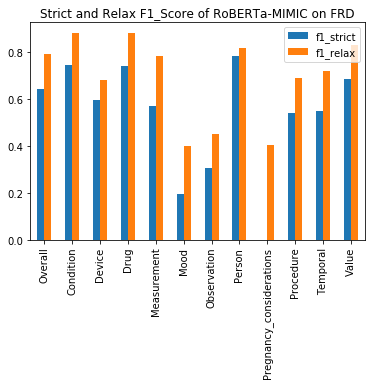

In [34]:
# plot performance by entity type
df.plot(x='type', y=['f1_strict', 'f1_relax'], title= f'Strict and Relax F1_Score of RoBERTa-MIMIC on FRD', kind="bar", rot=90)
plt.xlabel("");

In [35]:
with open(f"{outfolder}/{dataset}_results/{dataset}_strict_match_{model}.csv", "w", encoding="utf-8", newline='') as fstrict, open(f"{outfolder}/{dataset}_results/{dataset}_relax_match_{model}.csv", "w", encoding="utf-8", newline='') as frelax, open(f"{outfolder}/{dataset}_results/{dataset}_miss_match_{model}.csv", "w", encoding="utf-8", newline='') as fmiss:
    fs_writer = csv.writer(fstrict)
    fr_writer = csv.writer(frelax)
    fm_writer = csv.writer(fmiss)
    fs_writer.writerow(['NCT_ID', 'Entity', 'Offsets', 'Golden_Label', 'Prediction'])
    fr_writer.writerow(['NCT_ID', 'Entity', 'Offsets', 'Golden_Label', 'Prediction'])
    fm_writer.writerow(['NCT_ID', 'Entity', 'Offsets', 'Golden_Label', 'Prediction'])
    for nct_id, nct in predictions.items():
        for kk, vv in nct.items():
            if kk == "predicted":
                for k, v in vv.items():
                    if k == "strict":
                        for ent in v:
                            for i in ent:
                                i = i.split()
                                fs_writer.writerow([nct_id,i[0],' '.join(i[1:5]),i[5],i[6]])
                            fs_writer.writerow([])
                    if k == "relax":
                        for ent in v:
                            for i in ent:
                                i = i.split()
                                fr_writer.writerow([nct_id,i[0],' '.join(i[1:5]),i[5],i[6]])
                            fr_writer.writerow([])
                    if k == "miss":
                        for ent in v:
                            for i in ent:
                                i = i.split()
                                fm_writer.writerow([nct_id,i[0],' '.join(i[1:5]),i[5],i[6]])
                            fm_writer.writerow([])